# Instrumental Variables

In the previous section, we saw how linear regression can provide unbiased estimates under certain conditions. Multiple regression was used to account for omitted variable bias. However, even if a model is specified correctly and all of the relevant covariates are included, there are still a few situations that can lead to biased and/or inconsistent estimates. The most common case is when a variable exists that is known to be an important covariate, but is not observable. However, there are three additional situations where bias is introduced:

1. Imprecise measurement of the independent variable
2. Sample selection bias
3. Simultaneous causality

Biased estimates are a threat to the **internal validtiy** of an analysis, so ideally we want a method to account for these remaining issues. Each of these remaining problems have one thing in common: they result in one or more of the included covariates $X$ being correlated with the error term $\epsilon$. Said differently, a regressor is no longer **exogenous**, but is **endogeneous**. Instrumental variables is a technique for handling this general class of problems.

Intuitively, every regressor can be broken down into two components: the part that is correlated with the error term and the part that is not. If you could isolate the part that is uncorrelated with the error term, then you are back in the happy situation of being able to compute unbiased estimates. A valid instrumental variable does exactly that: it helps to isolate the variation in the endogenous regressor X that is uncorrelated with the error term. An instrumental variable $Z$ is any variable that satisfies the following conditions:

1. Relevance -- $corr(Z_i, X_i) \neq 0$
2. Exogeneity -- $corr(Z_i, \epsilon_i) = 0$

In words, the instrument must be correlated with the endogeneous regressor and it cannot be correlated with the error term. If we can identify a valid instrument, then we can achieve consistent estimates using the **two stage least squares** estimator.


## Instrumental Variables and Class Size

Consider our running example of the effect of class size on student achievement. Although there are certainly more, one important factor is the existence of outside learning opportunities. However, it is not immediately obvious how such a factor could be quantified and measured. Excluding such information would lead to biased estimates, but taking an instrumental variables approach provides us with the unbiased estimate we desire. 

Ideally, we can identify a variable that is correlated with class size (relevant) but uncorrelated with the presence of outside learning opportunities (exogenous) and other hard-to-measure factors. Another way to think about such a variable is as something that induces a random change (exogenously) in class size. Hoxby (2000) studied exactly this problem and suggested using potential enrollment as an instrument. Since birth dates/months are random, potential enrollment should be random as well. However, potential enrollment could be endogenous because parents may move to districts with better schools. In this situation, potential enrollment is correlated with unobserved factors about the school that would also effect test scores. Instead, Hoxby (2000) use the difference between potential enrollment and its long-term trend as the instrument.

### Endogeneity and Bias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.tools.tools import add_constant
from scipy.stats import ttest_1samp, ttest_ind
from scipy.linalg import cholesky
from sklearn.preprocessing import minmax_scale, scale

np.random.seed(12345)
primary_color = "#1c46bd"
secondary_color = "#14a758"

%matplotlib inline

In [2]:
def generate_simple_iv_sample_data(sample_size, correlation_coef=0.6):
    treatment = np.random.choice([0, 1], sample_size)

    treatment_df = pd.DataFrame()

    # Construct treatment and outside learning opportunities to be correlated
    corr_mat = np.array([
        [1.0, correlation_coef],
        [correlation_coef, 1.0]
    ])

    upper_cholesky = cholesky(corr_mat)
    random_data = np.random.normal(0, 1, size=(sample_size, 2))
    transformed_data = random_data @ upper_cholesky

    outside_learning_opp = minmax_scale(transformed_data[:, 0], feature_range=(0,1))
    outside_learning_opp = [1 if s > 0.5 else 0 for s in outside_learning_opp]

    treatment = minmax_scale(transformed_data[:, 1] ,feature_range=(0,1))
    # Ensure balanced classes
    treatment = [1 if s > np.median(treatment) else 0 for s in treatment]

    # Build up our dataset
    treatment_df["treated"] = treatment
    treatment_df["outside_learning"] = outside_learning_opp

    treatment_effect = 10
    outside_learning_opp_effect = 3
    treatment_df["score"] = (72 + 
                             treatment_effect*treatment_df["treated"] +
                             outside_learning_opp_effect*treatment_df["outside_learning"] + 
                             np.random.normal(loc=0.0, scale=5.0, size=sample_size))
    return treatment_df

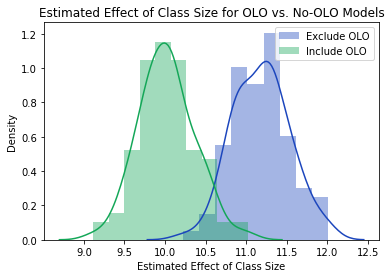

In [3]:
repeated_samples = 100 

no_olo_results = []
olo_results = []

for i in range(repeated_samples):
    sample_df = generate_simple_iv_sample_data(1000)
    res = smf.ols(formula="score ~ 1 + treated", data=sample_df).fit()
    no_olo_results.append(res.params["treated"])
    res = smf.ols(formula="score ~ 1 + treated + outside_learning", data=sample_df).fit()
    olo_results.append(res.params["treated"])

fix, ax = plt.subplots()
sns.distplot(no_olo_results, ax=ax, label="Exclude OLO", color=primary_color)
sns.distplot(olo_results, ax=ax, label="Include OLO", color=secondary_color)
ax.set_xlabel("Estimated Effect of Class Size")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Estimated Effect of Class Size for OLO vs. No-OLO Models")
plt.savefig("./images/iv_olo_bias.png", dpi=300)

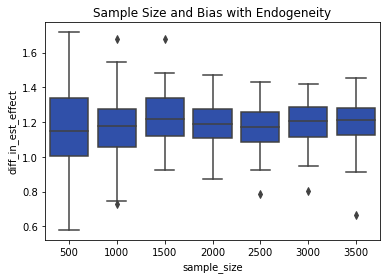

In [4]:
repeated_samples = 100 
sample_size = 1000
no_olo_results = []
x = []
y = []
sample_sizes = np.arange(500, 4000, 500)

for sample_size in sample_sizes:
    for i in range(repeated_samples):
        sample_df = generate_simple_iv_sample_data(sample_size)
        res_no_olo = smf.ols(formula="score ~ 1 + treated", data=sample_df).fit()
        res_olo = smf.ols(formula="score ~ 1 + treated + outside_learning", data=sample_df).fit()
        x.append(sample_size)
        y.append((res_no_olo.params["treated"] - res_olo.params["treated"]))
        
df = pd.DataFrame()
df["sample_size"] = x
df["diff_in_est_effect"] = y

fig, ax = plt.subplots()
sns.boxplot(x="sample_size", y="diff_in_est_effect",  data=df, ax=ax, color=primary_color)
ax.set_title("Sample Size and Bias with Endogeneity")
plt.savefig("./images/sample_size_bias_iv.png", dpi=300)

### Exogenous, but Irrelvant

First, let's consider an instrument that is exogenous, i.e. uncorrelated with the error term, but plays no part in determining test score outcomes (does not satisify the relevance criteria). In this example, assume that we have data on whether or not a student's parent drives a white car.

In [5]:
treatment_df = generate_simple_iv_sample_data(1000)
treatment_df["white_car"] = np.random.choice([0, 1], 1000)

# Sanity Check: OLS Omitting Outside Learning Opportunities
model = smf.ols(formula="score ~ 1 + treated", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     1123.
Date:                Tue, 09 Jul 2019   Prob (F-statistic):          1.40e-165
Time:                        22:46:36   Log-Likelihood:                -3079.0
No. Observations:                1000   AIC:                             6162.
Df Residuals:                     998   BIC:                             6172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.0706      0.235    310.326      0.000      72.609      73.533
treated       11.1598      0.333     33.513      0.000      10.506      11.813
==============================================================================
Omnibus:                        0.773   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.794
Skew:                          -0.067   Prob(JB):                        0.672
Kurtosis:                       2.970   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We constructed the data such that reducing class size improves test scores by 10 points and having outside learning opportunities improves test scores by 3 points. We also constructed the data so that treatment and outside learning opportunities are highly correlated. For the sake of illustration, we assume that outside learning opportunities are not directly observable. The model that was fit without including outside learning opportunities has a (upward) biased estiate of the effect of class size on performance.

Let's see if this bias disappears when we use car color as an instrument for outside learning opportunities. The IV estimate of the treatment effect can be achieved by fitting two models via least squares. In the first stage, we regress the treatment variable on our instrument.

In [6]:
first_stage_model = smf.ols(formula="treated ~ 1 + white_car", data=treatment_df)
first_stage_result = first_stage_model.fit()
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                treated   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8990
Date:                Tue, 09 Jul 2019   Prob (F-statistic):              0.343
Time:                        22:46:36   Log-Likelihood:                -725.34
No. Observations:                1000   AIC:                             1455.
Df Residuals:                     998   BIC:                             1464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5150      0.022     23.040      0.000       0.471       0.559
white_car     -0.0300      0.032     -0.948      0.343      -0.092       0.032
==============================================================================
Omnibus:                     3771.513   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.067
Skew:                          -0.000   Prob(JB):                     8.69e-37
Kurtosis:                       1.004   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression summary is already a little fishy. First, the model explains very little of the variance in the treatment variable. Second, one piece of advice (albeit folklore) is that for a good instrument, the first stage F-statistic should be greater than 10. Otherwise, the instrument is likely that the instrument is too weak to be useful. For the sake of illustration, we will continue with the second stage. For the second stage, we first compute the predicted values for treatment using the estimated coefficients from the first stage. Then, we regress the test scores outcome variable on the predicted treatment variables. 

In [7]:
predicted_values = first_stage_result.predict(treatment_df)
treatment_df["predicted_treatment"] = predicted_values

second_stage_model = smf.ols(formula="score ~ 1 + predicted_treatment", data=treatment_df)
second_stage_result = second_stage_model.fit()
second_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.228
Date:                Tue, 09 Jul 2019   Prob (F-statistic):             0.0727
Time:                        22:46:36   Log-Likelihood:                -3454.4
No. Observations:                1000   AIC:                             6913.
Df Residuals:                     998   BIC:                             6923.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              64.1368      8.082      7.936      0.000      48.278      79.996
predicted_treatment    29.0275     16.156      1.797      0.073      -2.676      60.731
==============================================================================
Omnibus:                       30.613   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.954
Skew:                          -0.027   Prob(JB):                     0.000566
Kurtosis:                       2.403   Cond. No.                         83.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The new estimate for the effect of treatment of test scores is effectively zero. However, we should not put much stock in this estimate since we constructed the instrument to violate the relevance assumption. In practice, we would never have chosen car color as an instrument since there is no theoretical reason why such information would have made for a valid instrument. Secondly, after seeing the results of the first stage, we would not have had any evidence that that proposed instrument was strong enough to yield valid results.

### Relevant, but Endogenous

We now consider what happens in the opposite case: the instrument is relevant (correlated with treatment), but not exogenous. 

In [8]:
def generate_iv_sample_data(sample_size, olo_treatment_corr=0.6, olo_enroll_corr=0.4, enroll_treatment_corr=0.6):
    # Construct correlation matrix such that:
    #  - OLO and Treatment are correlated
    #  - Treatment and % Change in Potential Enrollment are correlated
    #  - OLO and % Change in Potential Enrollment are correlated (endogenous)
    corr_mat = np.array([
        [1.0, olo_treatment_corr, olo_enroll_corr],
        [olo_treatment_corr, 1.0, enroll_treatment_corr],
        [olo_enroll_corr, enroll_treatment_corr, 1.0]
    ])

    upper_cholesky = cholesky(corr_mat)
    random_data = np.random.normal(0, 1, size=(sample_size, 3))
    transformed_data = random_data @ upper_cholesky

    # Boolean for outside learning opportunity
    outside_learning_opp = minmax_scale(transformed_data[:, 0], feature_range=(0,1))
    outside_learning_opp = [1 if s > 0.5 else 0 for s in outside_learning_opp]

    # Boolean for treatment
    treatment = minmax_scale(transformed_data[:, 1] ,feature_range=(0,1))
    treatment = [1 if s > np.median(treatment) else 0 for s in treatment]

    change_enroll = minmax_scale(transformed_data[:, 2] ,feature_range=(0, 1))

    # Build up our dataset
    treatment_df = pd.DataFrame()
    treatment_df["treatment"] = treatment
    treatment_df["outside_learning"] = outside_learning_opp
    treatment_df["change_enroll"] = change_enroll

    treatment_effect = 10
    outside_learning_opp_effect = 3
    treatment_df["score"] = (72 + 
                             treatment_effect*treatment_df["treatment"] +
                             outside_learning_opp_effect*treatment_df["outside_learning"] + 
                             np.random.normal(loc=0.0, scale=1.0, size=sample_size))
    return treatment_df

In [9]:
treatment_df = generate_iv_sample_data(1000)
first_stage_model = smf.ols(formula="treatment ~ 1 + change_enroll", data=treatment_df)
first_stage_result = first_stage_model.fit()
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              treatment   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     287.9
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           6.31e-57
Time:                        22:46:36   Log-Likelihood:                -599.07
No. Observations:                1000   AIC:                             1202.
Df Residuals:                     998   BIC:                             1212.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1964      0.043     -4.531      0.000      -0.281      -0.111
change_enroll     1.3743      0.081     16.967      0.000       1.215       1.533
==============================================================================
Omnibus:                      958.706   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.753
Skew:                          -0.061   Prob(JB):                     1.43e-14
Kurtosis:                       1.769   Cond. No.                         7.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Things look much less fishy this time! Our new instrument explains some of the variance in treatment. Additionally, we are well over the suggested F-statistic of 10, which suggests we might have some luck with this instrument.

In [10]:
predicted_values = first_stage_result.predict(treatment_df)
treatment_df["predicted_treatment"] = predicted_values

second_stage_model = smf.ols(formula="score ~ 1 + predicted_treatment", data=treatment_df)
second_stage_result = second_stage_model.fit()
second_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     321.5
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           1.53e-62
Time:                        22:46:36   Log-Likelihood:                -3052.1
No. Observations:                1000   AIC:                             6108.
Df Residuals:                     998   BIC:                             6118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              72.2294      0.379    190.603      0.000      71.486      72.973
predicted_treatment    12.2844      0.685     17.931      0.000      10.940      13.629
==============================================================================
Omnibus:                      218.575   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.489
Skew:                          -0.054   Prob(JB):                     5.94e-10
Kurtosis:                       1.996   Cond. No.                         5.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hmm... using the estimated treatment variable fom the first stage does not seem to have really altered the estimated ATE. If this were a valid instrument, we would expect that the estimate would be close to the true value of 10 that was used to construct the data.

### Valid, but Weak Instrument

In [11]:
treatment_df = generate_iv_sample_data(1000, olo_enroll_corr=0.0, enroll_treatment_corr=0.1)
first_stage_model = smf.ols(formula="treatment ~ 1 + change_enroll", data=treatment_df)
first_stage_result = first_stage_model.fit()
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              treatment   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.005
Date:                Tue, 09 Jul 2019   Prob (F-statistic):             0.0255
Time:                        22:46:36   Log-Likelihood:                -723.29
No. Observations:                1000   AIC:                             1451.
Df Residuals:                     998   BIC:                             1460.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3958      0.049      8.044      0.000       0.299       0.492
change_enroll     0.2376      0.106      2.237      0.026       0.029       0.446
==============================================================================
Omnibus:                     3809.275   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.336
Skew:                           0.001   Prob(JB):                     3.40e-36
Kurtosis:                       1.020   Cond. No.                         8.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The chosen instrument seems to explain very little of the variance in treatment. This is reflected in the F-statistic, which is below the suggested threshold of 10. Since we have a very weak instrument, the assumption of a normal distribution for the sampling distribution of the IV estimator is no longer valid regardless of the sample size. Therefore, we have no reason to belive that the IV estimate will be any less biased than the estimate from standard OLS.

In [12]:
predicted_values = first_stage_result.predict(treatment_df)
treatment_df["predicted_treatment"] = predicted_values

second_stage_model = smf.ols(formula="score ~ 1 + predicted_treatment", data=treatment_df)
second_stage_result = second_stage_model.fit()
second_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.071
Date:                Tue, 09 Jul 2019   Prob (F-statistic):             0.0246
Time:                        22:46:36   Log-Likelihood:                -3167.4
No. Observations:                1000   AIC:                             6339.
Df Residuals:                     998   BIC:                             6349.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              72.1053      2.581     27.934      0.000      67.040      77.171
predicted_treatment    11.5962      5.150      2.252      0.025       1.491      21.702
==============================================================================
Omnibus:                     4882.668   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.364
Skew:                           0.075   Prob(JB):                     7.30e-27
Kurtosis:                       1.307   Cond. No.                         35.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our expectation based on how weak the instrument is seems to have been born out in the second stage regression. The estimate is closer to the true vaule of 10, but barely. The IV estimate seems to be biased in the same direction as or original OLS estimate.

### Valid Instrument

Consider the population of the school district as a potential instrument. The number of classrooms for a particular grade is typically fixed (at least in the short run), therefore a large district is likely to have more potential students, and therefore larger classrooms on average. District population is therefore correlated with 

In [13]:
treatment_df = generate_iv_sample_data(1000,  olo_enroll_corr=0.0, enroll_treatment_corr=0.6)
first_stage_model = smf.ols(formula="treatment ~ 1 + change_enroll", data=treatment_df)
first_stage_result = first_stage_model.fit()
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              treatment   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     301.5
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           3.20e-59
Time:                        22:46:36   Log-Likelihood:                -593.79
No. Observations:                1000   AIC:                             1192.
Df Residuals:                     998   BIC:                             1201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.3459      0.051     -6.830      0.000      -0.445      -0.247
change_enroll     1.5817      0.091     17.365      0.000       1.403       1.760
==============================================================================
Omnibus:                      508.333   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.109
Skew:                          -0.016   Prob(JB):                     1.08e-12
Kurtosis:                       1.850   Cond. No.                         8.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Things look much less fishy this time! Our new instrument explains a lot of the variance in treatment. Additionally, we are well over the suggested F-statistic of 10, which suggests we might have some luck with this instrument.

In [14]:
predicted_values = first_stage_result.predict(treatment_df)
treatment_df["predicted_treatment"] = predicted_values

second_stage_model = smf.ols(formula="score ~ 1 + predicted_treatment", data=treatment_df)
second_stage_result = second_stage_model.fit()
second_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     196.9
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           5.84e-41
Time:                        22:46:36   Log-Likelihood:                -3108.3
No. Observations:                1000   AIC:                             6221.
Df Residuals:                     998   BIC:                             6230.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              73.9199      0.395    187.108      0.000      73.145      74.695
predicted_treatment     9.9891      0.712     14.033      0.000       8.592      11.386
==============================================================================
Omnibus:                      241.622   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.607
Skew:                          -0.112   Prob(JB):                     1.25e-10
Kurtosis:                       1.978   Cond. No.                         5.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that these standard errors are wrong and show what happens when correct ones are calculated